In [ ]:
!pip install translate langdetect pyspellchecker spacy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
import time
from datetime import datetime
import re
import os
from google.colab import drive
from translate import Translator
from langdetect import detect
from nltk.corpus import words
from spellchecker import SpellChecker
from nltk import FreqDist
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import ast
from wordcloud import WordCloud
from nltk.corpus import stopwords
import spacy
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2 , mutual_info_classif


In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
base_dir = '/content/drive/MyDrive/Quandrant/'
category_dataset_path = '/content/drive/MyDrive/Quandrant/input_datasets/category_dataset.csv'


In [ ]:
os.listdir(base_dir)

['Junior Data Scientist Interview.pdf',
 'category_dataset.csv',
 'Quadrant_Assignment_Shiva_Sai_Reddy_Gopireddy_20231020.ipynb']

### 1. Reading the Dataset

In [ ]:
category_df = pd.read_csv(category_dataset_path)
print('Total no of records : {}'.format(len(category_df)))
category_df.head(10)

Total no of records : 35315


,location_name,category,country_code
0,ATM Mandri,ATMs,ID
1,atm Mandiri,ATMs,ID
2,mandiri atm,ATMs,ID
3,AtmBank Mandiri,ATMs,ID
4,BankMandiriATM,ATMs,ID
5,mandiri OTM,ATMs,ID
6,ATM Bank Mandiri,ATMs,ID
7,Otm Mandire,ATMs,ID
8,Atm Cimb,ATMs,ID
9,Cimb ATM,ATMs,ID


In [ ]:
category_df.describe()

,location_name,category,country_code
count,35196,35315,35315
unique,35023,248,7
top,Mang Inasal,Pharmacies and Drug Stores,ID
freq,6,211,7253


In [ ]:
# country - wise record count
category_df.groupby(['country_code'])['location_name'].count().reset_index()

,country_code,location_name
0,ID,7234
1,IN,6601
2,MY,6344
3,PH,6160
4,SG,5766
5,TH,270
6,US,2821


In [ ]:
# category wise record count sorted in descending order
category_df.groupby(['category'])['location_name'].count().reset_index().sort_values(by='location_name',ascending=False).head(200)


,category,location_name
46,Casual Dining Restaurants,210
54,Clinics and Hospitals,210
57,Coffee Shops,210
210,Steakhouses,210
62,Confectionery Stores,210
...,...,...
169,Other Urban Transit Stations,120
117,Internet Cafes,120
34,Buddhist Monasteries,120
32,Breweries,120


In [ ]:
category_df.isnull().sum()

location_name    119
category           0
country_code       0
dtype: int64

In [ ]:
119/35315

0.0033696729435084244

**Key Observations**
1. Total records are : 35315
2. Location_name comprises of Null's of 119 (roughly 0.33 %)
3. Data is improperly cased

**Actions to be considered**
1. Since the null values are only constituting of 0.33% , we can drop the null records . Because imputing nulls with any statistical inference like mode doesn't make sense in this scenario.
2. since the dataset is improperly cased , we can make it to same case.

In [ ]:
# dropping the null records based on location_name field
category_df = category_df.dropna(subset=['location_name'])
print('Record count post deleting the null records : {}'.format(len(category_df)))

Record count post deleting the null records : 35196


##### NOTE : After carefully observing the dataset , it is a **TEXT CLASSIFICATION PROBLEM(MULTI-CLASS)** problem.

So rewriting the problem statement as follows:

Given a location_name , classify or predict the suitable category TAG for the location.

### 2. Data Preprocessing

**Quick checks to be performed**
1. Check for duplicates if any
2. check for misspelled words if any
3. check for special characters if any


In [ ]:
category_df.dtypes

location_name    object
category         object
country_code     object
dtype: object

In [ ]:
# Convert all text fields in the entire DataFrame to lowercase
lower_case_category_df = category_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
lower_case_category_df.head(2)

,location_name,category,country_code
0,atm mandri,atms,id
1,atm mandiri,atms,id


In [ ]:
lower_case_category_df.describe()

,location_name,category,country_code
count,35196,35196,35196
unique,34962,248,7
top,jolibee,casual dining restaurants,id
freq,6,210,7234


In [ ]:
# check the difference unique records before and after making it to lower case
pre_lower_unique_locations = len(category_df['location_name'].unique())
post_lower_unique_locations = len(lower_case_category_df['location_name'].unique())
count_difference = pre_lower_unique_locations-post_lower_unique_locations
print('Difference in count is {} and percentage is : {}'.format((count_difference),((count_difference)/pre_lower_unique_locations)*100))

Difference in count is 61 and percentage is : 0.1741712588870171


**Quick Observation:**
1. Once the dataset is made to lower case the unique values in the location_name is dropped , that indicates there are duplicate values in the location_name.

In [ ]:
# converting location name field into string type
lower_case_category_df['location_name']=lower_case_category_df['location_name'].astype(str)

In [ ]:
# Function to extract special characters and store them in a tuple
def extract_special_characters(text):
    special_characters = tuple(re.findall(r'[^a-zA-Z0-9\s]', text))
    return special_characters

lower_case_category_df['special_characters'] = lower_case_category_df['location_name'].apply(extract_special_characters)
lower_case_category_df.head(100)

,location_name,category,country_code,special_characters
0,atm mandri,atms,id,()
1,atm mandiri,atms,id,()
2,mandiri atm,atms,id,()
3,atmbank mandiri,atms,id,()
4,bankmandiriatm,atms,id,()
...,...,...,...,...
95,meametrobankndbank atm,atms,ph,()
96,landbank cash machine,atms,ph,()
97,rcbc atm,atms,ph,()
98,security bank atm,atms,ph,()


In [ ]:
# deriving a field to store the count of unique special characters
lower_case_category_df['special_characters_length'] = lower_case_category_df['special_characters'].apply(lambda x:len(x))
lower_case_category_df.head(10)

,location_name,category,country_code,special_characters,special_characters_length
0,atm mandri,atms,id,(),0
1,atm mandiri,atms,id,(),0
2,mandiri atm,atms,id,(),0
3,atmbank mandiri,atms,id,(),0
4,bankmandiriatm,atms,id,(),0
5,mandiri otm,atms,id,(),0
6,atm bank mandiri,atms,id,(),0
7,otm mandire,atms,id,(),0
8,atm cimb,atms,id,(),0
9,cimb atm,atms,id,(),0


In [ ]:
# Record count by special characters length
lower_case_category_df.groupby(['special_characters_length'])['location_name'].count().reset_index().sort_values('location_name',ascending=False).head()

,special_characters_length,location_name
0,0,29151
1,1,4973
2,2,777
3,3,119
4,4,27


In [ ]:
lower_case_category_df.query('special_characters_length==10').head()

,location_name,category,country_code,special_characters,special_characters_length
8893,แท่งขนมโทร,confectionery stores,th,"(แ, ท, ่, ง, ข, น, ม, โ, ท, ร)",10
25533,โอโซตสปา (ozotspa),pharmacies and drug stores,th,"(โ, อ, โ, ซ, ต, ส, ป, า, (, ))",10
25542,บ.ภัสสร (b.pasorn drug store),pharmacies and drug stores,th,"(บ, ., ภ, ั, ส, ส, ร, (, ., ))",10


**Quick Observation**
1. The dataset comprises of characters from other languages as well(such as Thai/siamese language ) , and hence these are considered to be special characters. So there is scope for translation and as well character encoding to UTF-8

In [ ]:
# List of shifted symbols and punctuation
shifted_symbols_and_punctuation = [
    '!', '@', '#', '$', '%', '^', '&', '*', '_', '-', '=', '+', '|', '\\', '~',
    '<', '>', ',', '.', '?', ';', ':', "'", '"', '/', '(', ')', '[', ']', '{', '}' , "’","²"
]

# Function to replace symbols with ""
def replace_symbols(text):
    for symbol in shifted_symbols_and_punctuation:
        text = text.replace(symbol, "")
    return text

# Create a new column "location_name_excluding_characters"
lower_case_category_df['location_name_excluding_characters'] = lower_case_category_df['location_name'].apply(replace_symbols)

# derive non_enlgish characters
def extract_non_english_alphabetical(text, default_value="****"):
    non_english_alpha_chars = re.sub(r'[\x00-\x7F]+', '', text)
    return non_english_alpha_chars if non_english_alpha_chars else default_value

lower_case_category_df['non_english_characters'] = lower_case_category_df['location_name_excluding_characters'].apply(extract_non_english_alphabetical)

# retrive non-english characters rows into a seperate df
non_english_location_df=lower_case_category_df.query('non_english_characters!="****"')
non_english_location_df.head()


,location_name,category,country_code,special_characters,special_characters_length,location_name_excluding_characters,non_english_characters
85,банк am atm,atms,my,"(б, а, н, к)",4,банк am atm,банк
523,lolipop playland and café,amusement and theme parks,id,"(é,)",1,lolipop playland and café,é
741,newport city parañaque,apartments,ph,"(ñ,)",1,newport city parañaque,ñ
1817,castrol motör oil indore,automotive parts and accessories retailers,in,"(ö,)",1,castrol motör oil indore,ö
2334,bikers café,bakeries,in,"(é,)",1,bikers café,é


In [ ]:
print('Country code wise non-english characters record counts : ')
non_english_location_df.groupby(['country_code'])['location_name'].count().reset_index()

Country code wise non-english characters record counts : 


,country_code,location_name
0,id,21
1,in,36
2,my,33
3,ph,55
4,sg,22
5,th,120
6,us,10


In [ ]:
# Function to translate non-English words to English
def translate_to_english(text, max_retries=3, retry_delay=5):
    try:
        # Detect the language of the text
        detected_lang = detect(text)

        # If the detected language is not English, translate to English
        if detected_lang != 'en':
            retries = 0
            while retries < max_retries:
                try:
                    translator = Translator(to_lang="en", from_lang=detected_lang)
                    translated_text = translator.translate(text)
                    return translated_text
                except Exception as e:
                    if "429 TOO MANY REQUESTS" in str(e):
                        print("API rate limit exceeded. Retrying after a delay...")
                        time.sleep(retry_delay)
                        retries += 1
                    else:
                        raise e  # Re-raise other exceptions
            print(f"Max retries reached. Unable to translate.")
        else:
            translated_text = text  # Keep English text as is

        return translated_text

    except Exception as e:
        print(f"Error: {e}")
        return text

# Apply the translation function to the DataFrame
non_english_location_df['translated_text'] = non_english_location_df['location_name_excluding_characters'].apply(translate_to_english)


<ipython-input-34-e749b90821f0>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_english_location_df['translated_text'] = non_english_location_df['location_name_excluding_characters'].apply(translate_to_english)


In [ ]:
non_english_location_df.head()

,location_name,category,country_code,special_characters,special_characters_length,location_name_excluding_characters,non_english_characters,translated_text
85,банк am atm,atms,my,"(б, а, н, к)",4,банк am atm,банк,bank am atm
523,lolipop playland and café,amusement and theme parks,id,"(é,)",1,lolipop playland and café,é,lolipop playland and café
741,newport city parañaque,apartments,ph,"(ñ,)",1,newport city parañaque,ñ,newport city parañaque
1817,castrol motör oil indore,automotive parts and accessories retailers,in,"(ö,)",1,castrol motör oil indore,ö,castrol motör oil indore
2334,bikers café,bakeries,in,"(é,)",1,bikers café,é,bikers cafe


In [ ]:
#non_english_location_df.to_csv(base_dir+'category_data_preprocessing_until_translation_v1.csv',index=False)
non_english_location_df.to_csv(base_dir+'category_data_preprocessing_until_translation_v2.csv',index=False)

**Quick checks so far**
1. Removed the special characters
2. Translated the words to english
3. Converted all to lower case



#### Generated a csv file comprising the translation of non-english words.

In [ ]:
non_english_location_df=pd.read_csv(base_dir+'category_data_preprocessing_until_translation_v2.csv')
non_english_location_df.head(2)

,location_name,category,country_code,special_characters,special_characters_length,location_name_excluding_characters,non_english_characters,translated_text
0,банк am atm,atms,my,"('б', 'а', 'н', 'к')",4,банк am atm,банк,bank am atm
1,lolipop playland and café,amusement and theme parks,id,"('é',)",1,lolipop playland and café,é,lolipop playland and café


In [ ]:
# Create  to filter df1
mask = lower_case_category_df['location_name_excluding_characters'].isin(non_english_location_df['location_name_excluding_characters'])

# Apply the mask to filter df1
exclusion_df = lower_case_category_df[~mask]

print('lower case df count : {}\nnon english df count: {}\nAfter excluding from non-english df match from lower case df , count is : {}'.format(
    len(lower_case_category_df),
    len(non_english_location_df),
    len(exclusion_df)
))

lower case df count : 35196
non english df count: 297
After excluding from non-english df match from lower case df , count is : 34899


In [ ]:
# concat exclusion_df and non_english_location_df again to get the translation info as well
translation_category_df = pd.concat([exclusion_df,non_english_location_df],axis=0)
print(len(translation_category_df))
translation_category_df.head(10)

35196


,location_name,category,country_code,special_characters,special_characters_length,location_name_excluding_characters,non_english_characters,translated_text
0,atm mandri,atms,id,(),0,atm mandri,****,NaN
1,atm mandiri,atms,id,(),0,atm mandiri,****,NaN
2,mandiri atm,atms,id,(),0,mandiri atm,****,NaN
3,atmbank mandiri,atms,id,(),0,atmbank mandiri,****,NaN
4,bankmandiriatm,atms,id,(),0,bankmandiriatm,****,NaN
5,mandiri otm,atms,id,(),0,mandiri otm,****,NaN
6,atm bank mandiri,atms,id,(),0,atm bank mandiri,****,NaN
7,otm mandire,atms,id,(),0,otm mandire,****,NaN
8,atm cimb,atms,id,(),0,atm cimb,****,NaN
9,cimb atm,atms,id,(),0,cimb atm,****,NaN


In [ ]:
translation_category_df['translated_text'].isnull().sum()

34899

In [ ]:
translation_category_df.isnull().sum()

location_name                             0
category                                  0
country_code                              0
special_characters                        0
special_characters_length                 0
location_name_excluding_characters        0
non_english_characters                    0
translated_text                       34899
dtype: int64

In [ ]:
# Define a lambda function to fill missing values
fill_missing = lambda row: row['location_name_excluding_characters'] if pd.isna(row['translated_text']) else row['translated_text']

# Apply the lambda function to fill missing values
translation_category_df['translated_text'] = translation_category_df.apply(fill_missing, axis=1)

translation_category_df['translated_text'].isnull().sum()

0

In [ ]:
translation_category_df.head(2)

,location_name,category,country_code,special_characters,special_characters_length,location_name_excluding_characters,non_english_characters,translated_text
0,atm mandri,atms,id,(),0,atm mandri,****,atm mandri
1,atm mandiri,atms,id,(),0,atm mandiri,****,atm mandiri


In [ ]:
translation_category_df[translation_category_df['translated_text'].str.contains('ERROR')]

,location_name,category,country_code,special_characters,special_characters_length,location_name_excluding_characters,non_english_characters,translated_text
77,café coffe day,coffee shops,in,"('é',)",1,café coffe day,é,"429 TOO MANY REQUESTS: {""ERROR"":{""ROOT_CAUSE"":..."
272,rvsco motöe lend,used car dealers,ph,"('ö',)",1,rvsco motöe lend,ö,"429 TOO MANY REQUESTS: {""ERROR"":{""ROOT_CAUSE"":..."


In [ ]:
# Define a lambda function to replace bad values
fill_bad_values = lambda row: row['location_name_excluding_characters'] if 'ERROR' in row['translated_text'] else row['translated_text']

# Apply the lambda function to fill errors
translation_category_df['translated_text'] = translation_category_df.apply(fill_bad_values, axis=1)
translation_category_df[translation_category_df['translated_text'].str.contains('ERROR')]

,location_name,category,country_code,special_characters,special_characters_length,location_name_excluding_characters,non_english_characters,translated_text


In [ ]:
translation_category_df.to_csv(base_dir+'category_data_till_translated_version.csv',index=False)

**CheckPoint:category_data_till_translated_version.csv**

In [ ]:
translated_category_df = pd.read_csv(base_dir+'category_data_till_translated_version.csv')


**Quick Summary so far**

1. Most of the data cleaning is done so far such as converting to lower case , dropping the nulls , replacing special characters with empty value , translating non-english alphabet to English .

**Next steps**

1. Need to figure out the mis-spelled words if any
2. Apply NLP techniques such as word tokenizing , stemming , lemmatization , removing stop words , word vectorizer etc., for better classification.





### 3. EDA (Exploratory Data Analysis)

#### 3.1 Word Tokenizing

In [ ]:
# Tokenize location names
translated_category_df['tokens'] = translated_category_df['translated_text'].apply(word_tokenize)
translated_category_df.head()


,location_name,category,country_code,special_characters,special_characters_length,location_name_excluding_characters,non_english_characters,translated_text,tokens
0,atm mandri,atms,id,(),0,atm mandri,****,atm mandri,"[atm, mandri]"
1,atm mandiri,atms,id,(),0,atm mandiri,****,atm mandiri,"[atm, mandiri]"
2,mandiri atm,atms,id,(),0,mandiri atm,****,mandiri atm,"[mandiri, atm]"
3,atmbank mandiri,atms,id,(),0,atmbank mandiri,****,atmbank mandiri,"[atmbank, mandiri]"
4,bankmandiriatm,atms,id,(),0,bankmandiriatm,****,bankmandiriatm,[bankmandiriatm]


In [ ]:
# Flatten the list of tokens
all_location_names_tokens = [token for sublist in translated_category_df['tokens'] for token in sublist]

# Compute word frequency
word_freq = FreqDist(all_location_names_tokens)


In [ ]:
word_freq

FreqDist({'shop': 759, 'store': 691, 'of': 662, 'the': 584, 'and': 560, 'center': 474, 'centre': 437, 'park': 373, 'city': 362, 'school': 353, ...})

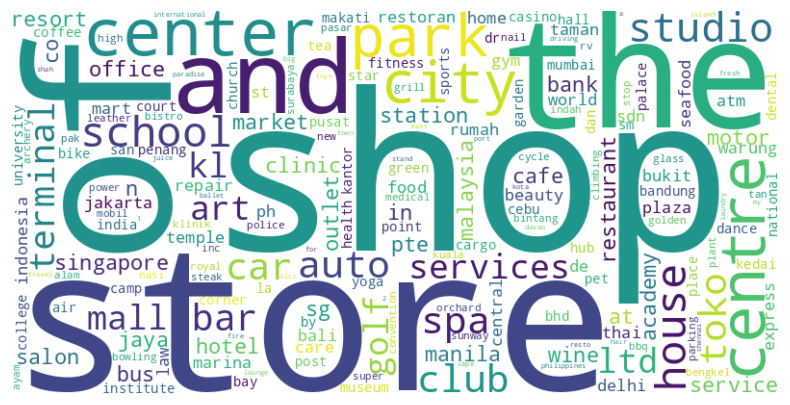

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Observations from the word cloud**
1. Most frequent words are store , shop , center , park , city and also some common stop words such as of, the , and , etc...

In [ ]:
translated_category_df.to_csv(base_dir+'tokenised_category_dataset_version.csv',index=False)

**CheckPoint**
'tokenised_category_dataset_version.csv'

In [ ]:
tokenized_category_df = pd.read_csv(base_dir+'tokenised_category_dataset_version.csv')
tokenized_category_df.head()

,location_name,category,country_code,special_characters,special_characters_length,location_name_excluding_characters,non_english_characters,translated_text,tokens
0,atm mandri,atms,id,(),0,atm mandri,****,atm mandri,"['atm', 'mandri']"
1,atm mandiri,atms,id,(),0,atm mandiri,****,atm mandiri,"['atm', 'mandiri']"
2,mandiri atm,atms,id,(),0,mandiri atm,****,mandiri atm,"['mandiri', 'atm']"
3,atmbank mandiri,atms,id,(),0,atmbank mandiri,****,atmbank mandiri,"['atmbank', 'mandiri']"
4,bankmandiriatm,atms,id,(),0,bankmandiriatm,****,bankmandiriatm,['bankmandiriatm']


#### 3.2 Stopword removal

In [ ]:
# download stopwords from nltk
nltk.download('stopwords')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
len(stopwords.words('english'))

179

In [ ]:
# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

In [ ]:
len(nlp.Defaults.stop_words)

326

In [ ]:
# Drop the duplicates
tokenized_category_df = tokenized_category_df.drop_duplicates()

In [ ]:
print(len(translated_category_df))

35196


In [ ]:
print(len(tokenized_category_df))

35154


In [ ]:
'of' in nlp.Defaults.stop_words

True

In [ ]:
tokenized_category_df['tokens'][0]

"['atm', 'mandri']"

In [ ]:
tokenized_category_df['tokens'] = tokenized_category_df['tokens'].apply(lambda x: literal_eval(x))


<ipython-input-147-24fabede7969>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_category_df['tokens'] = tokenized_category_df['tokens'].apply(lambda x: literal_eval(x))


In [ ]:
# Define a function to remove the stopwords

remove_stopwords = lambda word_list: [word for word in word_list if word not in nlp.Defaults.stop_words]

tokenized_category_df['clean_text'] = tokenized_category_df['tokens'].apply(remove_stopwords)
tokenized_category_df

<ipython-input-148-6194b1055683>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_category_df['clean_text'] = tokenized_category_df['tokens'].apply(remove_stopwords)


,location_name,category,country_code,special_characters,special_characters_length,location_name_excluding_characters,non_english_characters,translated_text,tokens,clean_text
0,atm mandri,atms,id,(),0,atm mandri,****,atm mandri,"[atm, mandri]","[atm, mandri]"
1,atm mandiri,atms,id,(),0,atm mandiri,****,atm mandiri,"[atm, mandiri]","[atm, mandiri]"
2,mandiri atm,atms,id,(),0,mandiri atm,****,mandiri atm,"[mandiri, atm]","[mandiri, atm]"
3,atmbank mandiri,atms,id,(),0,atmbank mandiri,****,atmbank mandiri,"[atmbank, mandiri]","[atmbank, mandiri]"
4,bankmandiriatm,atms,id,(),0,bankmandiriatm,****,bankmandiriatm,[bankmandiriatm],[bankmandiriatm]
...,...,...,...,...,...,...,...,...,...,...
35191,ongles salon de beauté,waxing salons,my,"('é',)",1,ongles salon de beauté,é,beauty salon nails,"[beauty, salon, nails]","[beauty, salon, nails]"
35192,estēe wax saloon,waxing salons,my,"('ē',)",1,estēe wax saloon,ē,in the case of salmon,"[in, the, case, of, salmon]","[case, salmon]"
35193,rhône wine and jazz bar,wine bars,in,"('ô',)",1,rhône wine and jazz bar,ô,rhône wine and jazz bar,"[rhône, wine, and, jazz, bar]","[rhône, wine, jazz, bar]"
35194,"miilésime,citta mall",wine stores,my,"('é', ',')",2,miilésimecitta mall,é,miilésimecitta mall,"[miilésimecitta, mall]","[miilésimecitta, mall]"


In [ ]:
tokenized_category_df.to_csv(base_dir+'category_dataset_post_removing_stopwords_version.csv',index=False)

**CheckPoint**: Stop words removed

In [ ]:
sw_category_df = pd.read_csv(base_dir+'category_dataset_post_removing_stopwords_version.csv')
sw_category_df.head()

,location_name,category,country_code,special_characters,special_characters_length,location_name_excluding_characters,non_english_characters,translated_text,tokens,clean_text
0,atm mandri,atms,id,(),0,atm mandri,****,atm mandri,"['atm', 'mandri']","['atm', 'mandri']"
1,atm mandiri,atms,id,(),0,atm mandiri,****,atm mandiri,"['atm', 'mandiri']","['atm', 'mandiri']"
2,mandiri atm,atms,id,(),0,mandiri atm,****,mandiri atm,"['mandiri', 'atm']","['mandiri', 'atm']"
3,atmbank mandiri,atms,id,(),0,atmbank mandiri,****,atmbank mandiri,"['atmbank', 'mandiri']","['atmbank', 'mandiri']"
4,bankmandiriatm,atms,id,(),0,bankmandiriatm,****,bankmandiriatm,['bankmandiriatm'],['bankmandiriatm']


In [ ]:
sw_category_df.isnull().sum()

location_name                         0
category                              0
country_code                          0
special_characters                    0
special_characters_length             0
location_name_excluding_characters    0
non_english_characters                0
translated_text                       0
tokens                                0
clean_text                            0
dtype: int64

In [ ]:
type(sw_category_df['clean_text'][0])

str

#### 3.3 Lemmatization

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def lemmatize_words(word_list):
    lemmatizer = WordNetLemmatizer()

    # Define a function to convert NLTK POS tags to WordNet POS tags
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return nltk.corpus.reader.wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return nltk.corpus.reader.wordnet.VERB
        elif treebank_tag.startswith('N'):
            return nltk.corpus.reader.wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return nltk.corpus.reader.wordnet.ADV
        else:
            return nltk.corpus.reader.wordnet.NOUN

    # Convert the string representation of a list to an actual list of words
    word_list = ast.literal_eval(word_list)

    # Apply lemmatization to the words
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for word, pos_tag in nltk.pos_tag(word_list)]

    return lemmatized_words


sw_category_df['lemmatized_words'] = sw_category_df['clean_text'].apply(lemmatize_words)


In [ ]:
sw_category_df[['location_name','category','lemmatized_words','country_code']].to_csv(base_dir+'category_df_lemmatized_version.csv',index=False)

#### 3.4 Feature Extraction

##### TF-IDF

In [ ]:
lemmatized_df = pd.read_csv(base_dir+'category_df_lemmatized_version.csv')
lemmatized_df.drop(['location_name','country_code'],axis=1,inplace=True)


In [ ]:
lemmatized_df=lemmatized_df[['lemmatized_words','category']]
lemmatized_df.head()

,lemmatized_words,category
0,"['atm', 'mandri']",atms
1,"['atm', 'mandiri']",atms
2,"['mandiri', 'atm']",atms
3,"['atmbank', 'mandiri']",atms
4,['bankmandiriatm'],atms


Some additional preprocessing on the lemmatized words

In [ ]:
# Function to process the list of words
def process_word_list(word_list):
    word_list = ast.literal_eval(word_list)
    processed_list = [word if not word.isdigit() else '' for word in word_list]  # Replace numbers with empty strings
    filtered_list = [word for word in processed_list if len(word) >= 3]  # Remove words with length < 3
    return filtered_list

# Apply the function to the DataFrame column
lemmatized_df['final_processed_location'] = lemmatized_df['lemmatized_words'].apply(process_word_list)
lemmatized_df= lemmatized_df[['final_processed_location','category']]

lemmatized_df.head()

,final_processed_location,category
0,"[atm, mandri]",atms
1,"[atm, mandiri]",atms
2,"[mandiri, atm]",atms
3,"[atmbank, mandiri]",atms
4,[bankmandiriatm],atms


In [ ]:
lemmatized_df['final_processed_location']= lemmatized_df['final_processed_location'].astype(str)

In [ ]:
lemmatized_df.to_csv(base_dir+'category_df_lemmatized_version_2.csv',index=False)

In [ ]:
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(lemmatized_df['final_processed_location'])

# Convert to a DataFrame for better visualization
tfidf_df = pd.DataFrame(data=X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df.head()

,10th,10thousand,13th,13unce,1800motorcycle,18tropicana,19place,1altitude,1colony,1mg,...,zzyzx,zén,électrick,ćaf,บภ,สสร,เก,เมโกร,แพร,ไทย
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
len(tfidf_df.columns) # total no of dimensions

30781

In [ ]:
tfidf_df.columns[310:500]

Index(['addias', 'addict', 'addventist', 'ade', 'adelphi', 'adem', 'adenture',
       'adg', 'adha', 'adharshila',
       ...
       'agro', 'agrocenter', 'agrogilingan', 'aguila', 'aguilera', 'aguinaldo',
       'agun', 'agung', 'agus', 'agusta'],
      dtype='object', length=190)

In [ ]:
# checking the quick summary stats for a subset of tf-idf
tfidf_df.iloc[:,3000:3100].describe()

,bharti,bhartiya,bharu,bharuna,bhasa,bhaskars,bhasker,bhatara,bhatigal,bhatinda,...,bidays,bidi,bidn,bieiyani,biel,biere,bifstok,big,bigas,bigbaazar
count,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,...,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000
mean,0.000093,0.000049,0.000184,0.000020,0.000016,0.000020,0.000017,0.000018,0.000028,0.000023,...,0.000017,0.000075,0.000017,0.000023,0.000018,0.000025,0.000019,0.000868,0.000017,0.000028
std,0.007898,0.005306,0.010445,0.003843,0.002998,0.003788,0.003157,0.003463,0.005334,0.004270,...,0.003118,0.007067,0.003186,0.004378,0.003374,0.004695,0.003521,0.021580,0.003117,0.005334
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.858466,0.667168,0.713295,0.720535,0.562151,0.710320,0.591945,0.649324,1.000000,0.800515,...,0.584590,0.733439,0.597441,0.820833,0.632673,0.880251,0.660141,0.705483,0.584469,1.000000


In [ ]:
tfidf_df.iloc[:,:100].describe()

,10th,10thousand,13th,13unce,1800motorcycle,18tropicana,19place,1altitude,1colony,1mg,...,aal,aalaya,aalim,aam,aamby,aamchi,aamco,aamdavad,aankh,aapartment
count,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,...,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000
mean,0.000019,0.000018,0.000016,0.000021,0.000028,0.000019,0.000017,0.000057,0.000018,0.000048,...,0.000017,0.000021,0.000019,0.000038,0.000020,0.000024,0.000020,0.000015,0.000016,0.000019
std,0.003472,0.003406,0.003027,0.003968,0.005334,0.003561,0.003166,0.007543,0.003422,0.006349,...,0.003276,0.003935,0.003526,0.005149,0.003771,0.004495,0.003771,0.002798,0.003072,0.003642
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.650925,0.638566,0.567587,0.744021,1.000000,0.667679,0.593689,1.000000,0.641657,0.904100,...,0.614150,0.737782,0.661130,0.779514,0.707107,0.842734,0.707107,0.524521,0.576068,0.682944


In [ ]:
tfidf_df.iloc[:,3000:3100].describe()

,bharti,bhartiya,bharu,bharuna,bhasa,bhaskars,bhasker,bhatara,bhatigal,bhatinda,...,bidays,bidi,bidn,bieiyani,biel,biere,bifstok,big,bigas,bigbaazar
count,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,...,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000,35154.000000
mean,0.000093,0.000049,0.000184,0.000020,0.000016,0.000020,0.000017,0.000018,0.000028,0.000023,...,0.000017,0.000075,0.000017,0.000023,0.000018,0.000025,0.000019,0.000868,0.000017,0.000028
std,0.007898,0.005306,0.010445,0.003843,0.002998,0.003788,0.003157,0.003463,0.005334,0.004270,...,0.003118,0.007067,0.003186,0.004378,0.003374,0.004695,0.003521,0.021580,0.003117,0.005334
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.858466,0.667168,0.713295,0.720535,0.562151,0.710320,0.591945,0.649324,1.000000,0.800515,...,0.584590,0.733439,0.597441,0.820833,0.632673,0.880251,0.660141,0.705483,0.584469,1.000000


In [ ]:
#tfidf_df.to_csv(base_dir+'tf_idf_category_dataset.csv',index=False)
tfidf_df.to_parquet(base_dir+'tf_idf_category_dataset.parquet',index=False)

#### 3.5 Feature Selection

In [ ]:
# reading tfidf and lemmatized data
#lemmatized_df= pd.read_csv(base_dir+'category_df_lemmatized_version_2.csv')

tfidf_df = pd.read_parquet(base_dir+'tf_idf_category_dataset.parquet')


In [ ]:
target_variable = lemmatized_df['category']

k = 100  # The number of top features to select
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_new = selector.fit_transform(tfidf_df, target_variable)


print(type(X_new))